<a href="https://colab.research.google.com/github/Khush-dev/Covid-19-Analysis/blob/main/Quaranteam_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data-based analysis of Covid-19 cases in India

###      $\qquad \qquad $ - Project Report for AE102 Course

### Abstract:

An analysis of new confirmed cases of various states has been made along with recovered cases.
An effort has been made to estimate
state-wise recovery duration of India’s COVID-19 patients. Determining the recovery time in each region is
intended to assist healthcare professionals in providing better care and planning of logistics. Attached Jupyter Notebook file is well-documented and interactive and can be used for individual analysis.

Keywords: COVID-19. Indian states. Recovery time. Statistical analysis. Recovered cases. Confirmed cases.

### Data and its source

This study used data provided by [COVID19-API](https://api.covid19india.org). The database used is [timeseries.min.json](https://api.covid19india.org/v4/min/timeseries.min.json). This data contains different categories of data for each Indian state on a day-to-day basis. To know more about the exact details, [click here](https://api.covid19india.org)


The first few code snippets contain functions to extract the needed data. 

In [ ]:
# Importing necessary modules
import requests
import json
import csv
from datetime import timedelta, date, datetime

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import t, norm, chi2
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8.0, 6.0
from ipywidgets import interact, fixed

List of states and union territories with order according to the data we get from our source

In [ ]:
st_ut = ['title',
 'andaman and nicobar islands',
 'andhra pradesh',
 'arunachal pradesh ',
 'assam',
 'bihar',
 'chhattisgarh',
 'chandigarh',
 'delhi',
 'daman and diu',
 'goa',
 'gujarat',
 'himachal pradesh',
 'haryana',
 'jharkhand',
 'jammu and kashmir',
 'karnataka',
 'kerala',
 'ladakh',
 'lakshadweep',
 'maharashtra',
 'meghalaya',
 'manipur',
 'madhya pradesh',
 'mizoram',
 'nagaland',
 'odisha',
 'punjab',
 'puducherry',
 'rajasthan',
 'sikkim',
 'telangana',
 'tamil nadu',
 'tripura',
 'india',
 #'un',
 'uttar pradesh',
 'uttarakhand',
 'west bengal']
for i in range(len(st_ut)):
   st_ut[i] = st_ut[i].capitalize()

In [ ]:
url2 = 'https://api.covid19india.org/v4/min/timeseries.min.json'#our data source
rq2 = requests.get(url2)
data2 = rq2.json()
del data2['UN'] #There was no documentation as to what it means, so we exclude that data.

One can custom add their own dates and get relevant data by uncommenting two lines of code. 

In [ ]:
fromdate = "2021-01-01"
todate = '2021-06-20'

#fromdate = input('Enter from date:(format YYYY-MM-DD): ')
#todate = input('Enter to date:(format YYYY-MM-DD): ')
##Uncomment the above lines to enter your own dates
start_date = datetime.strptime(fromdate, '%Y-%m-%d')
end_date = datetime.strptime(todate, '%Y-%m-%d')

In [ ]:
def daterange(start_date, end_date):      #function yields a single date in chronological order from the start_date to the end_date
    for n in range(int((end_date - start_date).days + 1)):
        yield start_date + timedelta(n)

Function for getting data about the required type_of_cases for each state in a specified range of dates(in the form of 2d lists)

Here, 'delta' refers to day-to-day values.
'total' refers to the cumulative value added uptill that particular date.


In [ ]:
def make_list(type_of_cases, delta_total = 'delta'):
  final_list = []
  for single_date in daterange(start_date, end_date):
    tmp_list = []
    for state in data2:
      try:
        tmp_list.append(data2[state]['dates'][str(single_date.date())][delta_total][type_of_cases])
      except:
        tmp_list.append(0)
    final_list.append(tmp_list)
  return final_list

In [ ]:
confirmed_list = make_list('confirmed')
confirmed_cases = pd.DataFrame(confirmed_list, index = pd.date_range(start_date, end_date), columns = st_ut[1:])
#Turning the list into a dataframe

In [ ]:
recovered_list = make_list('recovered')
recovered_cases = pd.DataFrame(recovered_list, index = pd.date_range(start_date, end_date), columns = st_ut[1:])
#Turning the list into a dataframe

In [ ]:
total_active_list = np.array(make_list('confirmed', 'total')) - np.array(make_list('recovered', 'total')) - np.array(make_list('deceased', 'total'))
total_active_cases = pd.DataFrame(total_active_list, index = pd.date_range(start_date, end_date), columns = st_ut[1:])
#Turning the list into a dataframe

 Note: Total active cases are calculated by subtracting the total number of recovered cases and deceased cases from the total number of confirmed cases.

### Total population data:

In [ ]:
total_active_cases.describe() 

,Andaman and nicobar islands,Andhra pradesh,Arunachal pradesh,Assam,Bihar,Chhattisgarh,Chandigarh,Delhi,Daman and diu,Goa,Gujarat,Himachal pradesh,Haryana,Jharkhand,Jammu and kashmir,Karnataka,Kerala,Ladakh,Lakshadweep,Maharashtra,Meghalaya,Manipur,Madhya pradesh,Mizoram,Nagaland,Odisha,Punjab,Puducherry,Rajasthan,Sikkim,Telangana,Tamil nadu,Tripura,India,Uttar pradesh,Uttarakhand,West bengal
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,1.710000e+02,171.000000,171.000000,171.000000
mean,78.725146,54886.871345,890.561404,15968.426901,22111.017544,2281.730994,39465.695906,22267.730994,419.093567,6885.812865,33485.426901,7895.333333,23314.590643,12304.473684,13142.216374,143652.233918,125532.912281,627.567251,494.842105,257900.783626,1656.502924,2220.286550,27572.017544,829.865497,1479.350877,26710.748538,23183.333333,4346.590643,43506.280702,1233.280702,20341.029240,75245.865497,1651.526316,1.130372e+06,61002.380117,18820.736842,36966.625731
std,82.363187,73403.871187,1317.419519,19885.158401,35051.291724,2613.249030,46629.421301,32241.950215,618.341161,9441.821489,45695.562963,10924.733153,34668.076354,18698.705753,17042.175846,190475.620952,118256.181170,671.153905,625.717540,229620.754921,2450.903325,3322.443274,34493.222095,1184.745502,1948.892363,35124.426215,23402.706797,5613.197735,66355.523708,1500.552554,23539.283172,97332.891345,2542.608363,1.205960e+06,94182.278883,25183.982437,46776.903918
min,0.000000,575.000000,0.000000,1603.000000,290.000000,123.000000,2721.000000,1019.000000,31.000000,464.000000,1672.000000,231.000000,813.000000,428.000000,593.000000,5520.000000,24192.000000,30.000000,0.000000,31437.000000,12.000000,24.000000,1829.000000,6.000000,156.000000,535.000000,2077.000000,166.000000,1195.000000,126.000000,1640.000000,3952.000000,25.000000,1.375780e+05,1634.000000,1747.000000,3110.000000
25%,8.000000,1298.500000,4.000000,1679.500000,756.000000,240.500000,4323.500000,1791.000000,36.000000,767.000000,3832.000000,581.500000,1701.000000,555.000000,897.500000,6942.500000,48934.000000,62.500000,64.000000,53403.500000,53.500000,63.500000,3382.500000,22.000000,193.500000,746.000000,2963.500000,286.000000,2362.000000,151.000000,2057.000000,4615.000000,54.500000,1.862610e+05,3643.000000,2288.500000,4273.000000
50%,40.000000,4715.000000,57.000000,2966.000000,3982.000000,925.000000,11126.000000,4212.000000,95.000000,1379.000000,8947.000000,2442.000000,4661.000000,1637.000000,2600.000000,21271.000000,68617.000000,241.000000,132.000000,163586.000000,152.000000,203.000000,8324.000000,77.000000,271.000000,1982.000000,14366.000000,846.000000,7159.000000,257.000000,5053.000000,12157.000000,83.000000,4.878440e+05,10080.000000,4460.000000,8476.000000
75%,134.000000,101720.500000,1928.500000,35430.500000,26629.000000,3370.500000,73493.000000,28191.500000,524.000000,9500.000000,43954.500000,10950.500000,27805.000000,15492.000000,21209.000000,246685.500000,171833.000000,1406.000000,1008.500000,439948.000000,2788.500000,4065.500000,43402.000000,1726.000000,2732.500000,55810.500000,34750.500000,7399.000000,55220.500000,2740.000000,34563.000000,124236.500000,2699.500000,1.916198e+06,73972.000000,27952.000000,62638.000000
max,278.000000,211554.000000,3918.000000,56295.000000,115152.000000,8653.000000,131245.000000,99752.000000,2244.000000,32953.000000,148297.000000,40052.000000,116867.000000,61195.000000,52848.000000,605515.000000,445692.000000,2041.000000,2345.000000,701614.000000,8255.000000,9613.000000,111366.000000,3543.000000,5677.000000,100235.000000,79963.000000,18277.000000,212753.000000,4542.000000,80695.000000,313048.000000,8362.000000,3.750934e+06,310783.000000,85120.000000,132181.000000


In [ ]:
confirmed_cases.describe()    #our required data... notice the discrepencies in our data- especially the min values

,Andaman and nicobar islands,Andhra pradesh,Arunachal pradesh,Assam,Bihar,Chhattisgarh,Chandigarh,Delhi,Daman and diu,Goa,Gujarat,Himachal pradesh,Haryana,Jharkhand,Jammu and kashmir,Karnataka,Kerala,Ladakh,Lakshadweep,Maharashtra,Meghalaya,Manipur,Madhya pradesh,Mizoram,Nagaland,Odisha,Punjab,Puducherry,Rajasthan,Sikkim,Telangana,Tamil nadu,Tripura,India,Uttar pradesh,Uttarakhand,West bengal
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,14.391813,5662.438596,95.684211,1557.274854,2730.421053,243.754386,4158.479532,4718.847953,41.830409,662.982456,3376.000000,848.730994,2953.760234,1341.695906,1115.923977,11034.836257,11979.304094,60.461988,55.222222,23629.643275,186.421053,209.795322,3201.578947,74.497076,72.052632,3203.982456,2489.947368,448.625731,3759.426901,78.403509,1911.391813,9382.941520,168.918129,114901.011696,6546.152047,1448.678363,5436.514620
std,18.186412,7508.781657,139.183902,2128.067334,4405.517814,268.852526,5410.508699,7975.181946,71.080405,942.952263,4485.799719,1236.497115,4455.217678,2056.949180,1447.431169,14512.891918,11750.479085,74.978056,75.158795,21985.216598,273.226276,297.481861,4362.775999,103.093640,103.145315,4135.949033,2556.745434,580.808696,5857.142488,110.900569,2376.910180,11619.906233,263.643151,127129.539849,10914.377824,2241.523780,7040.081218
min,0.000000,30.000000,0.000000,3.000000,21.000000,0.000000,141.000000,94.000000,0.000000,29.000000,185.000000,12.000000,67.000000,31.000000,43.000000,317.000000,1054.000000,0.000000,0.000000,652.000000,0.000000,0.000000,87.000000,0.000000,0.000000,53.000000,124.000000,8.000000,60.000000,0.000000,0.000000,438.000000,0.000000,8579.000000,0.000000,-374.000000,119.000000
25%,1.000000,122.500000,0.000000,21.000000,88.000000,40.000000,377.500000,218.500000,0.000000,69.500000,439.000000,64.000000,168.500000,62.000000,87.500000,560.500000,3410.000000,3.500000,3.500000,3711.000000,3.000000,7.000000,304.000000,2.000000,1.000000,94.500000,264.000000,28.000000,179.000000,2.000000,189.000000,553.500000,1.000000,15483.500000,194.500000,67.500000,257.000000
50%,4.000000,984.000000,3.000000,52.000000,351.000000,108.000000,1034.000000,444.000000,7.000000,140.000000,778.000000,239.000000,528.000000,184.000000,256.000000,2792.000000,5980.000000,17.000000,15.000000,14123.000000,20.000000,18.000000,735.000000,7.000000,7.000000,245.000000,1463.000000,125.000000,475.000000,8.000000,493.000000,2089.000000,7.000000,56152.000000,682.000000,263.000000,896.000000
75%,26.500000,10127.000000,205.000000,3434.000000,3387.500000,397.500000,6464.000000,4257.500000,38.500000,915.000000,4228.000000,1061.500000,3598.500000,1909.500000,1762.000000,17906.500000,18555.000000,115.000000,100.000000,40168.500000,361.000000,437.500000,4354.000000,145.500000,116.500000,6189.500000,3780.000000,713.500000,4759.500000,149.500000,3119.500000,16739.000000,285.500000,190966.000000,6933.500000,2012.000000,9173.500000
max,97.000000,24171.000000,497.000000,6573.000000,15853.000000,895.000000,17397.000000,28395.000000,359.000000,4195.000000,14605.000000,5424.000000,15786.000000,8075.000000,5443.000000,50112.000000,43529.000000,362.000000,345.000000,68631.000000,1183.000000,1032.000000,13601.000000,345.000000,366.000000,12852.000000,9042.000000,2049.000000,18298.000000,420.000000,11451.000000,36184.000000,879.000000,414280.000000,37944.000000,9642.000000,20846.000000


In [ ]:
recovered_cases.describe()      #our required data... notice the discrepencies in our data- especially the min values

,Andaman and nicobar islands,Andhra pradesh,Arunachal pradesh,Assam,Bihar,Chhattisgarh,Chandigarh,Delhi,Daman and diu,Goa,Gujarat,Himachal pradesh,Haryana,Jharkhand,Jammu and kashmir,Karnataka,Kerala,Ladakh,Lakshadweep,Maharashtra,Meghalaya,Manipur,Madhya pradesh,Mizoram,Nagaland,Odisha,Punjab,Puducherry,Rajasthan,Sikkim,Telangana,Tamil nadu,Tripura,India,Uttar pradesh,Uttarakhand,West bengal
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.00000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.00000,171.000000,171.000000,171.000000
mean,13.748538,5282.222222,80.953216,1361.614035,2691.637427,241.087719,4113.023392,4654.766082,41.491228,636.19883,3363.742690,833.666667,2922.970760,1318.269006,1069.192982,10231.690058,11687.005848,59.046784,52.877193,22753.865497,156.923977,156.298246,3213.152047,54.339181,56.649123,3010.421053,2406.783626,423.666667,3761.076023,63.842105,1830.590643,8915.421053,142.087719,110847.71345,6521.356725,1398.684211,5327.350877
std,17.021818,7437.372562,131.047715,1992.591240,4394.107237,269.987513,5274.554881,7416.823694,71.503630,940.69279,4310.503393,1205.443589,4519.441429,2051.678431,1410.836829,14865.170791,13277.273573,72.960167,79.515534,22235.294911,254.222969,253.147107,4158.767580,82.708145,113.681261,4117.539115,2503.162667,576.761058,6038.723099,101.234403,2498.330790,11359.292132,266.791301,124363.45843,10875.402669,2135.693896,7292.532034
min,0.000000,51.000000,0.000000,11.000000,-2837.000000,0.000000,120.000000,75.000000,0.000000,33.00000,264.000000,14.000000,57.000000,28.000000,32.000000,287.000000,1660.000000,0.000000,0.000000,1355.000000,0.000000,0.000000,175.000000,0.000000,0.000000,52.000000,146.000000,9.000000,51.000000,0.000000,0.000000,453.000000,0.000000,9500.00000,0.000000,-265.000000,198.000000
25%,1.000000,131.500000,0.000000,23.000000,85.000000,34.000000,380.000000,258.500000,0.000000,62.50000,511.500000,59.500000,176.000000,61.500000,83.500000,543.500000,3836.000000,4.000000,2.000000,3748.500000,3.500000,5.000000,353.500000,2.000000,1.000000,91.500000,263.500000,26.000000,182.000000,2.500000,195.000000,545.500000,1.000000,15988.00000,251.000000,78.500000,295.500000
50%,4.000000,377.000000,3.000000,70.000000,391.000000,84.000000,1152.000000,602.000000,5.000000,104.00000,1006.000000,226.000000,519.000000,173.000000,230.000000,1283.000000,5332.000000,14.000000,14.000000,13165.000000,13.000000,23.000000,857.000000,5.000000,6.000000,244.000000,1426.000000,47.000000,562.000000,9.000000,394.000000,1241.000000,7.000000,32269.00000,789.000000,272.000000,879.000000
75%,25.000000,10397.500000,139.000000,3062.000000,3148.000000,427.000000,6435.000000,5158.000000,46.500000,783.50000,4259.000000,1128.500000,3411.500000,1685.500000,1815.500000,16817.000000,17678.000000,121.000000,91.000000,37603.500000,198.000000,165.000000,4905.000000,100.500000,50.000000,6370.000000,3638.000000,688.000000,4112.000000,91.000000,3047.500000,19397.500000,126.500000,195040.00000,6854.000000,1837.500000,10588.000000
max,72.000000,24819.000000,513.000000,6266.000000,15800.000000,963.000000,18746.000000,27421.000000,339.000000,4008.00000,15365.000000,5021.000000,16192.000000,8331.000000,4956.000000,61766.000000,99651.000000,315.000000,483.000000,82266.000000,977.000000,1247.000000,14562.000000,335.000000,965.000000,12077.000000,9059.000000,2017.000000,29459.000000,420.000000,17183.000000,33646.000000,1066.000000,422391.00000,40852.000000,8731.000000,19670.000000


### Initial Plotting

Initial analysis reveals that there is some discrepancy in the data provided, since some values are negative. We get the following plots in our initial plotting.

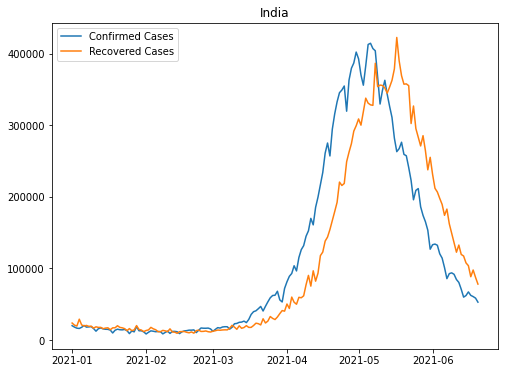

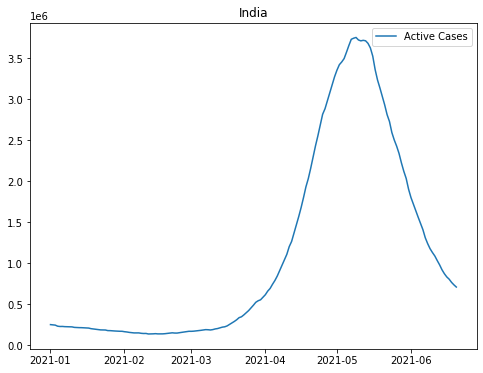

In [ ]:
plt.figure(1)       #initial plotting
plt.plot(confirmed_cases['India'], label = 'Confirmed Cases');
plt.plot(recovered_cases['India'], label = 'Recovered Cases');
plt.legend()
plt.title('India')
plt.figure(2)
plt.plot(total_active_cases['India'], label = 'Active Cases');    
plt.legend()
plt.title('India');

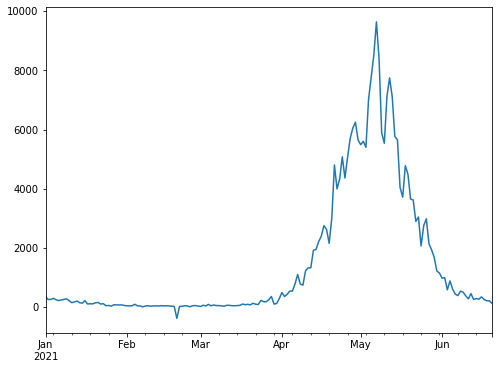

In [ ]:
confirmed_cases['Uttarakhand'].plot();

We find that there is an error in the data since the number of new cases can never be negative and therefore we cannot except that value.


In [ ]:
confirmed_cases[confirmed_cases['Uttarakhand']<0].index

DatetimeIndex(['2021-02-20'], dtype='datetime64[ns]', freq='D')

In [ ]:
confirmed_cases['Uttarakhand'][pd.date_range('2021-02-10','2021-02-28')]

2021-02-10     35
2021-02-11     48
2021-02-12     49
2021-02-13     44
2021-02-14     54
2021-02-15     47
2021-02-16     53
2021-02-17     44
2021-02-18     41
2021-02-19     26
2021-02-20   -374
2021-02-21     30
2021-02-22     32
2021-02-23     54
2021-02-24     47
2021-02-25     17
2021-02-26     53
2021-02-27     59
2021-02-28     43
Freq: D, Name: Uttarakhand, dtype: int64

Clearly this seems to be a mistake. We will exclude all such values.

In [ ]:
confirmed_cases[confirmed_cases<0] = np.nan   #excluding negative values
recovered_cases[recovered_cases<0] = np.nan
total_active_cases[total_active_cases<0] = np.nan

In [ ]:
confirmed_cases.to_csv('/content/confirmed_cases.csv', index = True)      #saving our data in a csv file
recovered_cases.to_csv('/content/recovered_cases.csv', index = True)
total_active_cases.to_csv('/content/total_active_cases.csv', index = True)

Now that we have our data let us find the true marginal distributions and the true joint distribution

### True Distribution

Here, we compute the true parameters(mean) of the confirmed and recovered cases of different states and plot the corresponding joint distributions.

#### Choosing the states
Since states with less number of cases tend to have more jaggered/unstable curves, we chose five states with the most number of cases(confirmed and recovered)\\\\To do this, we calculate the mean of confirmed and recovered cases for all states and choose the first five after sorting them in ascending order.\\ \\The following is the code snippet for choosing the five states:

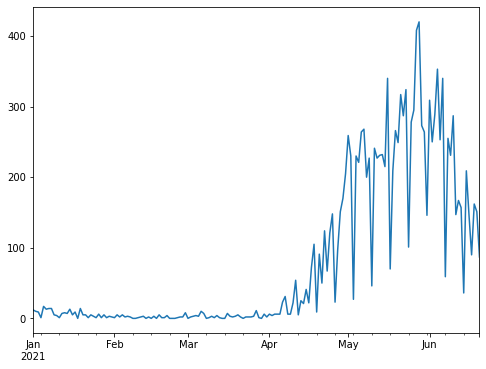

In [ ]:
confirmed_cases['Sikkim'].plot();

States with lesser number of cases seem to have more jaggered/unstable curves. We will make a detailed study of the states with most number of cases.

To do this, we calculate the mean of confirmed and recovered cases for all states and choose the first five after sorting them in ascending order. 

The following is the code snippet for choosing the five states:

In [ ]:
confirmed_cases.mean().sort_values(ascending = False)[:6]

India            114901.011696
Maharashtra       23629.643275
Kerala            11979.304094
Karnataka         11034.836257
Tamil nadu         9382.941520
Uttar pradesh      6546.152047
dtype: float64

In [ ]:
recovered_cases.mean().sort_values(ascending = False)[:6]

India            110847.713450
Maharashtra       22753.865497
Kerala            11687.005848
Karnataka         10231.690058
Tamil nadu         8915.421053
Uttar pradesh      6521.356725
dtype: float64

#### Plotting number of cases against time

The following code snippet stores the dataframe in the needed format:

In [ ]:
maharashtra_cases = pd.DataFrame([ confirmed_cases['Maharashtra'].rename('confirmed_cases') ,recovered_cases['Maharashtra'].rename('recovered_cases') ]).T
maharashtra_cases.describe()    #This snippet saves dataframe in the following format

,confirmed_cases,recovered_cases
count,171.000000,171.000000
mean,23629.643275,22753.865497
std,21985.216598,22235.294911
min,652.000000,1355.000000
25%,3711.000000,3748.500000
50%,14123.000000,13165.000000
75%,40168.500000,37603.500000
max,68631.000000,82266.000000


In [ ]:
#similarly for other states
kerala_cases = pd.DataFrame([ confirmed_cases['Kerala'].rename('confirmed_cases') ,recovered_cases['Kerala'].rename('recovered_cases') ]).T
karnataka_cases = pd.DataFrame([ confirmed_cases['Karnataka'].rename('confirmed_cases') ,recovered_cases['Karnataka'].rename('recovered_cases') ]).T
tamil_nadu_cases = pd.DataFrame([ confirmed_cases['Tamil nadu'].rename('confirmed_cases') ,recovered_cases['Tamil nadu'].rename('recovered_cases') ]).T
uttar_pradesh_cases = pd.DataFrame([ confirmed_cases['Uttar pradesh'].rename('confirmed_cases') ,recovered_cases['Uttar pradesh'].rename('recovered_cases') ]).T

all_cases = pd.DataFrame([ confirmed_cases['India'].rename('confirmed_cases') ,recovered_cases['India'].rename('recovered_cases') ]).T

#This dictionary maps the state name to its dataframe. It comes handy
states = {'Maharashtra':maharashtra_cases, 'Kerala':kerala_cases, 'Karnataka':karnataka_cases, 'Tamil Nadu':tamil_nadu_cases, 'Uttar Pradesh': uttar_pradesh_cases, 'India': all_cases}

The following plot shows the number of new confirmed cases and the number of recovered cases against time.

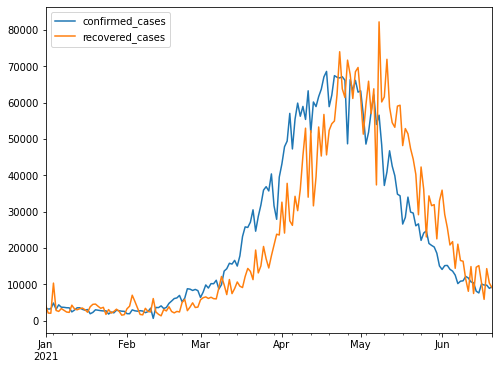

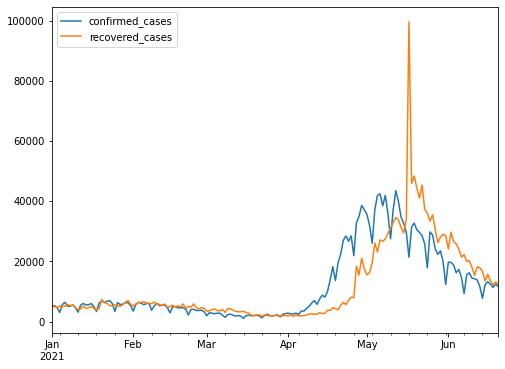

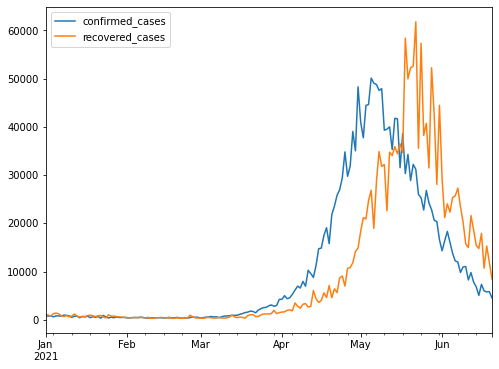

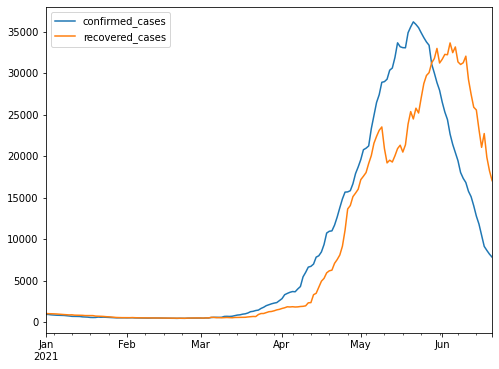

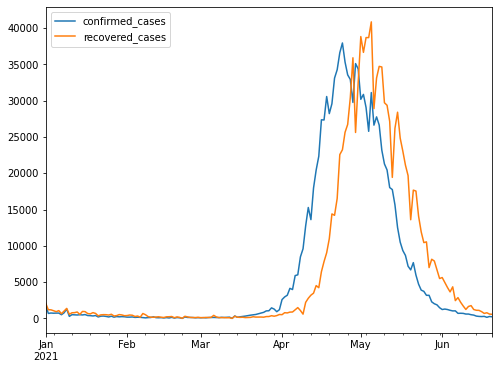

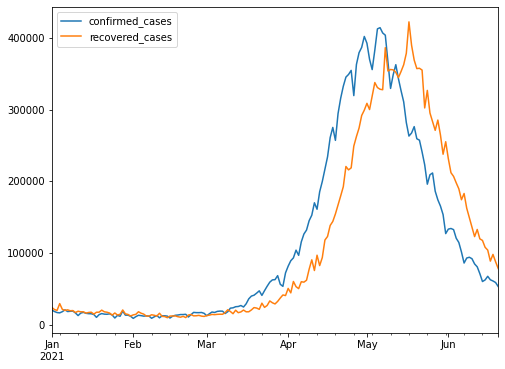

In [ ]:
for state in states:
  states[state].plot();

## True Distributions

### True Joint Distribution

Confirmed cases vs Recovered cases plotted using contours:

Note that the true marginal distribution is also plotted at the top and right sides for Confirmed cases and recovered cases respectively

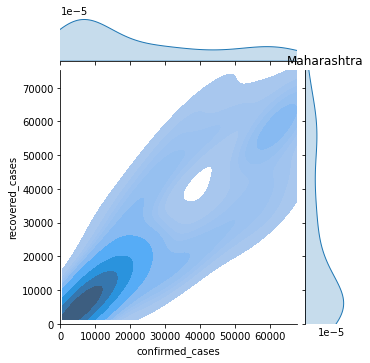

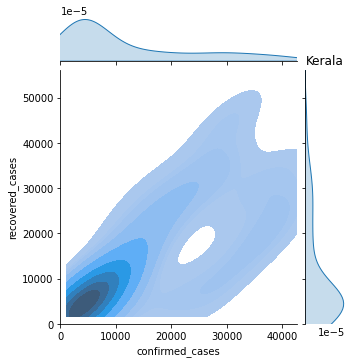

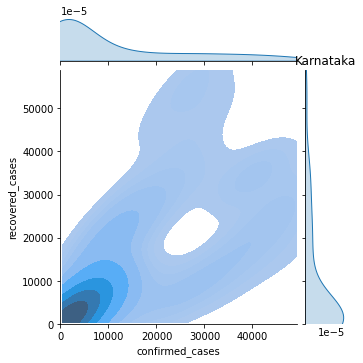

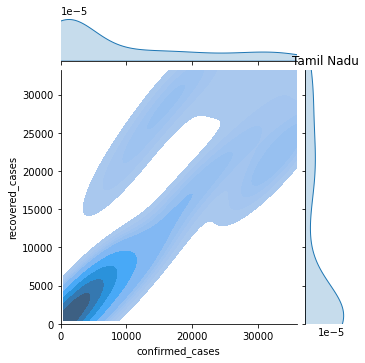

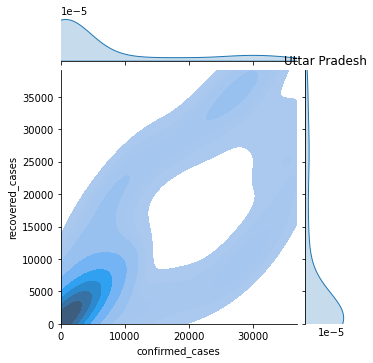

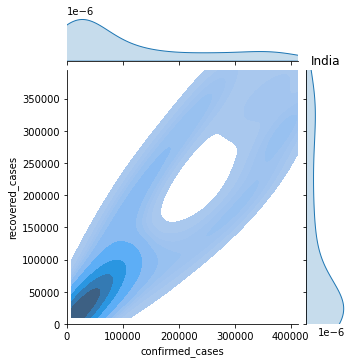

In [ ]:
for state in states:
  sns.jointplot(data=states[state], x="confirmed_cases", y="recovered_cases", kind="kde", cut = 0, fill = True,
              xlim = (0, states[state]['confirmed_cases'].quantile(0.995)), ylim = (0, states[state]['recovered_cases'].quantile(0.995)), height = 5 );
  plt.title(state);

Reorganizing dataframe by adding extra columns to use split sns.violinplot,  sns.histplot and sns.catplot

In [ ]:
def make_df(state_df, state_name):
  new_df = pd.DataFrame(state_df['confirmed_cases'].rename('no_of_cases'))
  new_df['type:'] = 'confirmed_cases'
  new_df2 = pd.DataFrame(state_df['recovered_cases'].rename('no_of_cases'))
  new_df2['type:'] = 'recovered_cases'
  df = pd.concat([new_df, new_df2])
  df['state'] = state_name
  return df

In [ ]:
main_df = pd.concat([make_df(maharashtra_cases, 'Maharashtra'), make_df(kerala_cases, 'Kerala'),    #just another dataframe for usage in a particular format
                     make_df(karnataka_cases, 'Karnataka'), make_df(tamil_nadu_cases, 'Tamil Nadu'), 
                     make_df(uttar_pradesh_cases, 'Uttar Pradesh') ])

### True Marginal Distribution

Below figure shows the marginal distributions for each state.

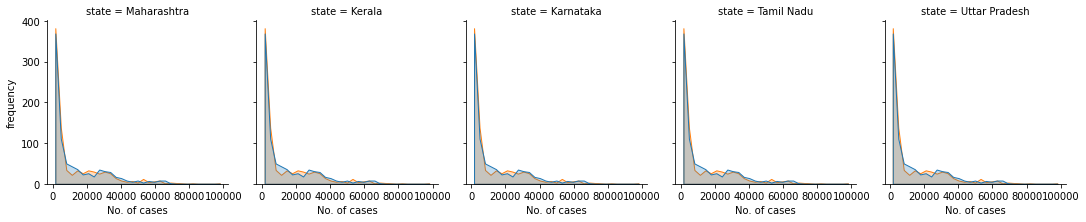

In [ ]:
g = sns.FacetGrid(data=main_df, col = 'state');
g.map(sns.histplot, data=main_df, x = "no_of_cases", hue="type:", element = 'poly');
g.set_axis_labels('No. of cases', 'frequency');

#### Plotting the joint distributions using violinplots

This can be used to compare means and interquartile ranges for different states

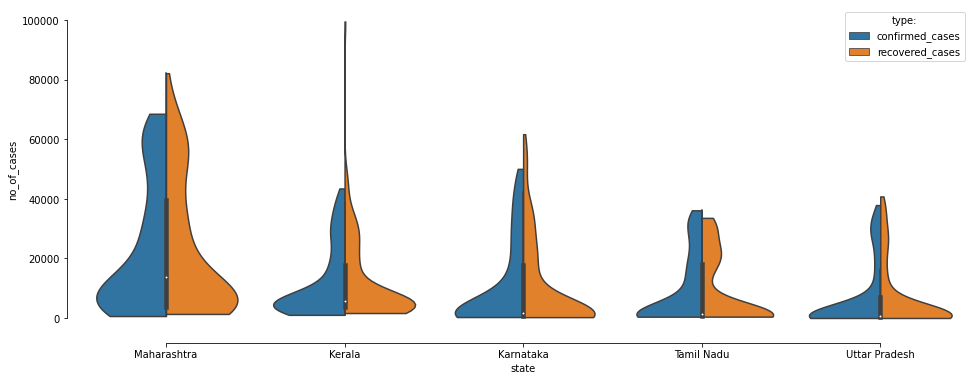

In [ ]:
rcParams['figure.figsize'] = 16.0, 6.0
sns.violinplot(data = main_df,x = 'state', y = 'no_of_cases', hue = 'type:', split = True, cut = 0)
sns.despine(offset=10, trim=True);
rcParams['figure.figsize'] = 8.0, 6.0

#### Joint distributions using sns.catplot

This can be used to compare the actual magnitudes of confirmed and recovered cases of various states\\Maharashtra stands out as the state with the highest confirmed cases and a relatively high recovery rate as well.

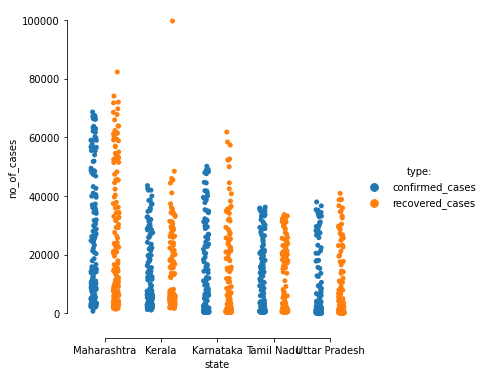

In [ ]:
sns.catplot(data = main_df,x = 'state', y = 'no_of_cases', hue = 'type:', dodge = True)
sns.despine(offset=10, trim=True);

## Sampling Distribution

Since there’s a lot of data to handle we must use sampling of data to make things easier and less hectic. Since there are theories of probability and statistics which prove that we can infact use the properties of sampled data to the true data, we will now move on to define some functions to sample the data to make out lives easier.

We first define a function such that given number of samples and state and the range of dates, it samples and gives us sampled data from the original data with replacement. Hence the function ‘s1’ does exactly that

In [ ]:
# sampling functions
def s1(n,state_data,fromdate,todate):     #returns a single sample of n random values from state_data in the given data range
    sample=state_data[fromdate:todate].sample(n=n,replace=True)
    return sample

#### Point Estimate

The below table shows the sample mean and sample standard deviation which are unbiased point estimators of the true mean and true standard deviation. True parameters are calculated in the

In [ ]:
s1(50, maharashtra_cases, fromdate, todate).describe()

,confirmed_cases,recovered_cases
count,50.000000,50.000000
mean,19648.660000,19211.540000
std,20826.168851,21567.744576
min,2171.000000,1622.000000
25%,3571.250000,3260.750000
50%,8807.000000,6603.000000
75%,28891.500000,31798.250000
max,66358.000000,71966.000000


The functions returns the sampled data in the form of a DataFrame, which we will use to get our required results.

We now need a function that returns the mean and standard deviations of the number of confirmed and recovered cases in the given date ranges. The function ‘sampled_data’ does exactly the thing we want. It inputs the state of interest and the date ranges and returns the mean and standard deviation.


In [ ]:
def sampled_data(n_samples, n,state_data,fromdate,todate):       #returns sample parameters for n_samples samples
    mean_confirmed=np.zeros(n_samples)
    mean_recovered=np.zeros(n_samples)
    std_confirmed=np.zeros(n_samples)
    std_recovered=np.zeros(n_samples)
    for i in range(n_samples):
        df=s1(n,state_data,fromdate,todate)
        mean_confirmed[i]=df["confirmed_cases"].mean(skipna=True)
        std_confirmed[i]=np.std(df["confirmed_cases"])
        mean_recovered[i]=df["recovered_cases"].mean(skipna=True)
        std_recovered[i]=(np.std(df["recovered_cases"]))
    return pd.Series(mean_confirmed),pd.Series(std_confirmed),pd.Series(mean_recovered),pd.Series(std_recovered)   
        

Here is an example of the output of the above function

In [ ]:
a, b, c, d = sampled_data(1000, 20, maharashtra_cases, fromdate, todate)
a.mean(), b.mean(), c.mean(), d.mean()

(23556.100799999982, 21218.713197864286, 22638.187, 21359.874644106432)

The above mentioned mean is the true mean. The true standard deviation is approximately the mean of the standard deviations

### Confidence Interval

The following function takes in data, which is in the above mentioned format and returns the confidence interval using two methods.
One method is to return the corresponding percentile values while the other method uses the fact that the sampling distribution is a $t_{n-1}$ distribution

In [ ]:
# Returns a 100*(1-alpha)% = 95% confidence interval
def conf_interval(data,n, alpha = 0.05):    
    a,b,c,d=data
    mean_confirmed=np.mean(a)
    std_confirmed=np.mean(b)
    mean_recovered=np.mean(c)
    std_recovered=np.mean(d)
    t_value=t(n-1).ppf(1-alpha/2)
    upper_limit_confirmed=uc=mean_confirmed+t_value*(std_confirmed/n**0.5)
    lower_limit_confirmed=lc=mean_confirmed-t_value*(std_confirmed/n**0.5)
    upper_limit_recovered=ur=mean_recovered+t_value*(std_recovered/n**0.5)
    lower_limit_recovered=lr=mean_recovered-t_value*(std_recovered/n**0.5)
    q_lc, q_uc = a.quantile([alpha/2, 1-alpha/2])
    q_lr, q_ur = c.quantile([alpha/2, 1-alpha/2])
    return np.array([[uc,lc] , [ur, lr]]), np.array([[q_uc,q_lc] , [q_ur, q_lr]])

The following function plots a $t_{n-1}$ distribution against the histogram representing the true sampling distribution. 

In [ ]:
def show_interval(state, n_samples = 1000,n= 20,alpha = 0.05, fromdate = fromdate, todate = todate):    #plots graphs corresponding to a particular state
  state_data = states[state]
  sampling_dist = sampled_data(n_samples,n,state_data,fromdate,todate)
  [uc_lc , ur_lr], [q_uc_lc, q_ur_lr] = conf_interval(sampling_dist, n, alpha)

  plt.figure(1)
  plt.hist(np.sqrt(n)*(sampling_dist[0] - sampling_dist[0].mean() )/sampling_dist[1].mean(), density = True);
  x = np.linspace(-3, 3)
  plt.plot(x, t(df = n-1).pdf(x), 'g--', label = 't_n-1');
  plt.vlines(np.sqrt(n)*(uc_lc- np.mean(sampling_dist[0]))/np.mean(sampling_dist[1]), [0,0], [0.3, 0.3], label = 'analytical confidence interval')
  plt.vlines(np.sqrt(n)*(q_uc_lc- np.mean(sampling_dist[0]))/np.mean(sampling_dist[1]), [0,0], [0.3, 0.3], label = 'quantile values', color = 'red')
  plt.title('Confirmed Cases')
  plt.legend()

  plt.figure(2)
  plt.hist(np.sqrt(n)*(sampling_dist[2]- np.mean(sampling_dist[2]))/np.mean(sampling_dist[3]), color = 'orange', density = True);
  plt.plot(x, t(df = n-1).pdf(x), 'g--', label = 't_n-1');
  plt.vlines(np.sqrt(n)*(ur_lr- np.mean(sampling_dist[2]))/np.mean(sampling_dist[3]), [0,0], [0.3, 0.3], label = 'analytical confidence interval')
  plt.vlines(np.sqrt(n)*(q_ur_lr- np.mean(sampling_dist[2]))/np.mean(sampling_dist[3]), [0,0], [0.3, 0.3], label = 'quantile values', color = 'red')
  plt.title('Recovered Cases')
  plt.legend()

The plot below shows the true sampling distribution. The black vlines show the analytically obtained confidence interval i.e. the one using $t_{n-1}$ distribution. Notice that these are always symmetrically placed w.r.t. the centre. The red vlines show the confidence interval obtained by quantile values.

Also, note that the $t_{n-1}$ distribution fits the sampling distribution curve nicely.

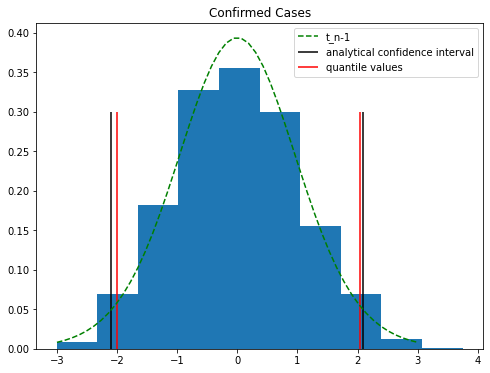

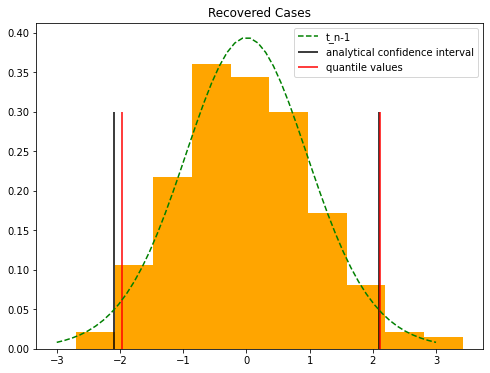

In [ ]:
show_interval('Maharashtra')

Following is an interactive widget (which, ofcourse would not be functional in the pdf report.)

In [ ]:
interact(show_interval, n_samples = (100, 5000, 100), n = (5, 50, 5), state = ['Maharashtra', 'Kerala', 'Karnataka_cases', 'Tamil Nadu', 'Uttar Pradesh','India'], alpha = (0.01, 0.5, 0.01), fromdate = fixed(fromdate), todate = fixed(todate) );

interactive(children=(Dropdown(description='state', options=('Maharashtra', 'Kerala', 'Karnataka_cases', 'Tami…

Try playing with the values. Increasing the number of samples gives a better fit to the normal distribution and a smaller difference between intervals obtained using both the methods.

Increasing the alpha value results in a shorter interval.

## Hypothesis Testing

In real world we usually do not have complete population data. To analyze such a situation we will assume that we have only two samples of data. We will use one to make our null  and alternate hypothesis and then use the other sample to test how likely is it to get such a value given the hypothesis is true.

Since we know the true mean, we will plot that too, so that we get an estimate of how close does our sample means lie to the true mean.

We first code up a function to get various data like mean and standard deviation of different samples and the true population from their sampled and non-sampled dataframes.

In [ ]:
def func(size_of_samples, state, fromdate, todate ):#letter r is for recovered, letter c for confirmed
  
  state_name = states[state]
  first_sample = s1(size_of_samples, state_name, fromdate, todate)
  test_sample = s1(size_of_samples, state_name, fromdate, todate)
  cfirst_sample, rfirst_sample = first_sample['confirmed_cases'], first_sample['recovered_cases']
  cstate_name, rstate_name = state_name['confirmed_cases'], state_name['recovered_cases']
  ctest_sample, rtest_sample = test_sample['confirmed_cases'], test_sample['recovered_cases']

  cx_bar = cfirst_sample.mean()
  cs = cfirst_sample.std()
  cmu = cstate_name.mean()
  csigma = cstate_name.std()
  ctest_x_bar = ctest_sample.mean()
  ctest_s = ctest_sample.std()
  rx_bar = rfirst_sample.mean()
  rs = rfirst_sample.std()
  rmu = rstate_name.mean()
  rsigma = rstate_name.std()
  rtest_x_bar = rtest_sample.mean()
  rtest_s = rtest_sample.std()

  return cx_bar, cs, cmu, csigma, ctest_x_bar, ctest_s , rx_bar, rs, rmu, rsigma, rtest_x_bar, rtest_s

Then we call this function from another function(func2-given below) to use the data to plot it for visualisation.

### Null Hypothesis:

**$\quad H_0 : \mu = \overline{X_0}  $**

$\quad$ i.e. The mean of the first sample is the true mean of the sampling distribution.

### Alternate Hypothesis
$\quad H_1 : \mu \neq \overline{X_0}  $

$\quad$ i.e. The mean of the first sample is not the true mean of the sampling distribution.

Our  initial approach was to plot a t-distribution centred at the mean of the first sample and scale it by the standard deviation of the first sample, then we plot vlines indicating our level of significance(alpha - $\alpha$), then the p-values.

**$ Z = \sqrt{n} \cdot \frac{\overline{X} - \mu}{S} \sim t_{n-1}$**

In [ ]:
def func2(n,state,alpha = 0.05, fromdate = fromdate, todate = todate):#c = confirmed, r = recovered
  
  y = np.linspace(-3, 3)  
  cmiu_0, cs_0 , cmu , csigma, ctest_mean , ctest_std, rmiu_0, rs_0 , rmu , rsigma, rtest_mean , rtest_std = func(n, state, fromdate, todate)
  t_value=np.array([t(n-1).ppf(1-alpha/2), t(n-1).ppf(alpha/2)])
  plt.figure(figsize=(20,10))

  #confirmed
  plt.subplot(1,2,1)
  plt.plot(y, t(n-1).pdf(y), 'g--', label = 't_n-1');
  plt.vlines(np.sqrt(n)*(cmu- cmiu_0)/(cs_0), 0, 0.3, label = 'true mean of entire distribution', colors='b')
  z_val_c = np.sqrt(n)*(ctest_mean- cmiu_0)/(cs_0)
  p_val_c = 1 - np.abs(t(n-1).cdf(z_val_c) - t(n-1).cdf(-z_val_c))
  plt.vlines(z_val_c, 0, 0.3, label = 'test mean with p-value: %.3f' % p_val_c, colors = 'r')
  plt.vlines(t_value, [0,0], [0.3, 0.3], label = 'confidence interval')
  plt.title('confirmed cases')
  plt.legend()
  
  #recovered
  plt.subplot(1,2,2)
  plt.plot(y, t(n-1).pdf(y), 'g--', label = 't_n-1');
  plt.vlines(np.sqrt(n)*(rmu- rmiu_0)/(rs_0), 0, 0.3, label = 'true mean of entire distribution', colors='b')
  z_val_r = np.sqrt(n)*(rtest_mean- rmiu_0)/(rs_0)
  p_val_r = 1 - np.abs(t(n-1).cdf(z_val_r) - t(n-1).cdf(-z_val_r))
  plt.vlines(z_val_r, 0, 0.3, label = 'test mean with p-value: %.3f' % p_val_r, colors = 'r')
  plt.vlines(t_value, [0,0], [0.3, 0.3], label = 'confidence interval')
  plt.title('recovered cases')
  plt.legend()

Since displacing and scaling of the t-distribution is a relatively tougher task, we diplace and scale everything else to the t-distribution. Hence the plot(t-distribution and vlines) being closer to the origin than any of the means.

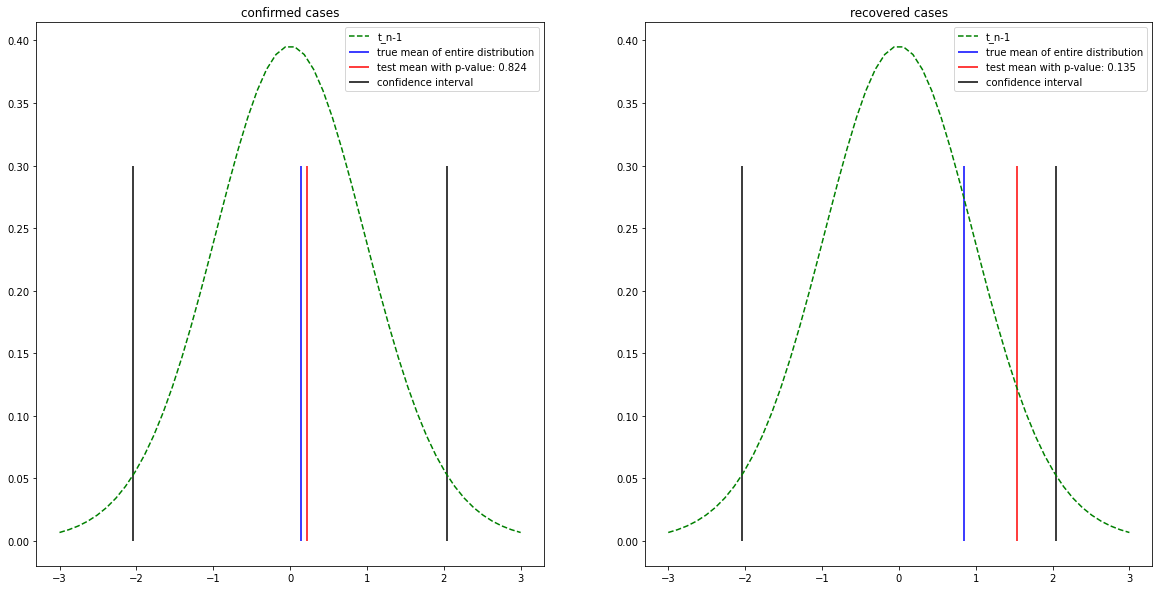

In [ ]:
func2(30, 'Maharashtra')

We do the above given procedure for both recovered and confirmed cases, then we use the interact function to(you guessed it) interact with the code.The true mean is added to see how close either of the sample means are to the true statistic.

In [ ]:
interact(func2, n = (15, 50, 1), state = ['Maharashtra', 'Kerala', 'Karnataka_cases', 'Tamil Nadu', 'Uttar Pradesh','India'], alpha = (0.01, 0.5, 0.01), fromdate = fixed(fromdate), todate = fixed(todate) );

interactive(children=(IntSlider(value=32, description='n', max=50, min=15), Dropdown(description='state', opti…

#### Conclusion

Using the above given code we get to understand how accurate our initial guess from a sample is.We take the data from the first sample and treat it to be true, then using a test sample we check if it is within our confidence interval.

What does a mean(statistic) mean(meaning) for our Covid-19 system?
It gives us solid numbers(the mean and then by playing with interact how often our estimated mean is accurate).
From this information one can make further useful or essential inferences like when, where, whether and how much of a resource is to be employed for some task, or drive other policies or decisions required to be made to curb the virus without knowing all the information. (which is of utmost importance so that we can come to campus)

## Regression

An attempt to estimate the average recovery time for individual states has been made.

### Method:

The standard relation between [Incidence and Prevalence](https://doi.org/10.1093/oxfordjournals.aje.a113043) :

$ \text{Prevalence} = \frac{\text{Incidence}}{\text{Duration}} = \frac{\frac{\text{Active Cases}}{\text{Exposed Population}}} {\frac{\text{New Cases}}{\text{Exposed Population}} }$

$\text{Duration  of disease} = \frac{\text{Active Cases of COVID - 19}}{\text{New Cases of COVID - 19}}$

To find the above ratio, we find the coefficients of regression for $ \log_e{\text{Active Cases}} \text{  -vs-  } \log_e{\text{New Cases}} $

Since the difference of log values corresponds to ratio of the terms involved, we take $e^\text{intercept}$ as our average duration in days.

For more details, refer to [this](https://doi.org/10.1016/j.cegh.2021.100740).

#### Gathering data 

A 7 day moving average is used in order to account for the jaggered shape of our data. (A 7 day moving average also reduces the number of data points with 0 cases, helping us take those points in account in our calculations  (Because $\log0$ is not defined(-inf)) )


In [ ]:
#getting data for our regression model
#7 day moving average to get a smoother curve
moving_avg_confirmed_cases = confirmed_cases.rolling(window = 7).mean() #alternate way: pd.DataFrame(make_list('confirmed', 'delta7'), index = pd.date_range(start_date, end_date), columns = st_ut[1:])/7
moving_avg_active_cases = total_active_cases.rolling(window = 7).mean()

Then, 15 states with highest number of cases are selected. All over India cases are also included.

In [ ]:
state_list = list(dict(moving_avg_confirmed_cases.mean().sort_values(ascending = False)[:16]).keys())#sorting by mean values

The follow dictionary maps the name of the state to its dataframe. That comes handy for the next list of functions.

In [ ]:
log_dict = {}
for state in state_list:
  log_dict[state] = pd.concat( [np.log(moving_avg_confirmed_cases[state].rename('log_new_cases')[7:]), np.log(moving_avg_active_cases[state].rename('log_active_cases')[7:]) ], axis = 1)

### Correlation test

We first check if there is any correlation between our random variables, which are $ \log_e{\text{Active Cases}} \text{  and  } \log_e{\text{New Cases}} $

In [ ]:
corr_list = []
for state in state_list:
  corr_list.append(log_dict[state].corr()['log_active_cases'][0])
for i,state in enumerate(state_list):
  print(state, corr_list[i])

India 0.9844543785389401
Maharashtra 0.9723477963726552
Kerala 0.9718163104135349
Karnataka 0.9830532951881404
Tamil nadu 0.9913713615162063
Uttar pradesh 0.9657561757095225
Andhra pradesh 0.9903944743312322
West bengal 0.9733773295113046
Delhi 0.9664080800039299
Chandigarh 0.9584186877560711
Rajasthan 0.9735109916609932
Gujarat 0.9359261059353947
Madhya pradesh 0.9625039793465078
Odisha 0.9936258031227639
Haryana 0.9871366722547777
Bihar 0.9814944043235639


The above data suggests a strong correlation between our random variables.

So, Let us start with regression plotting.

### Regression plotting

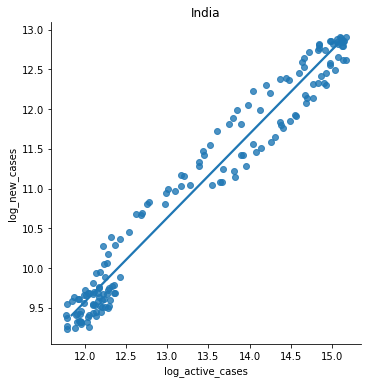

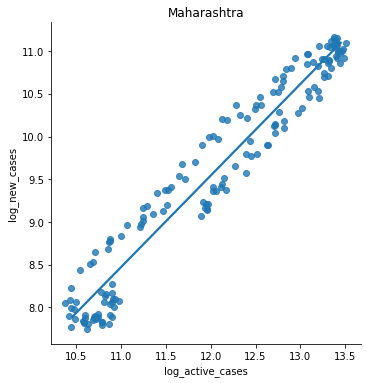

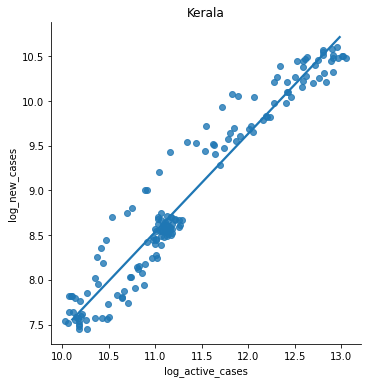

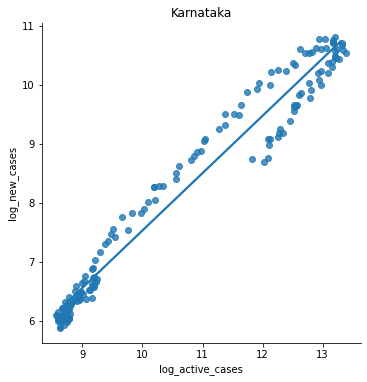

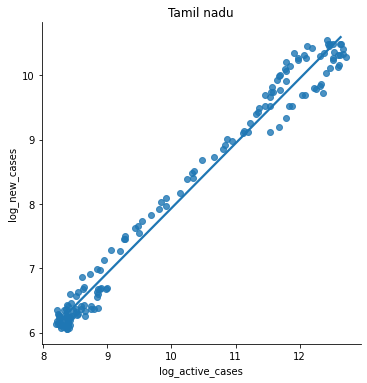

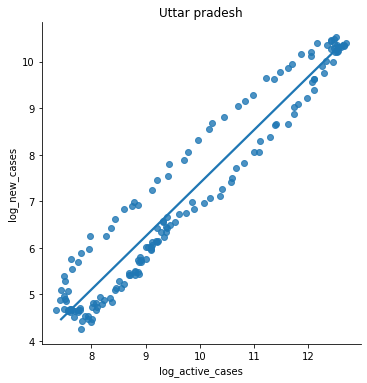

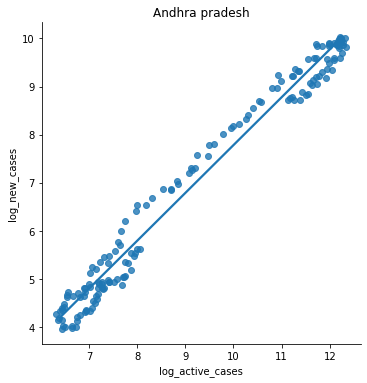

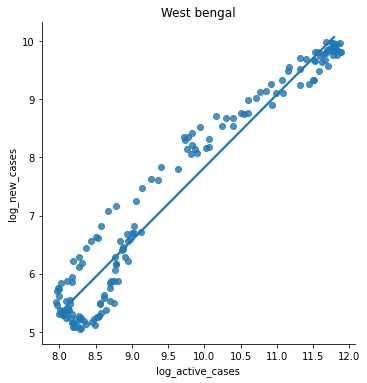

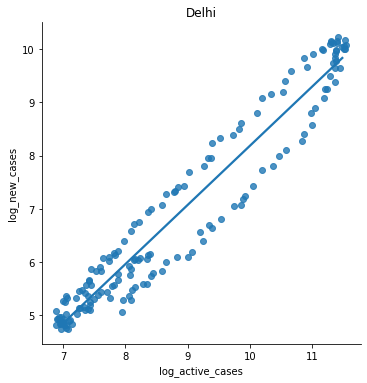

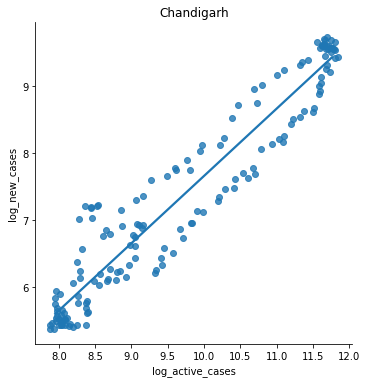

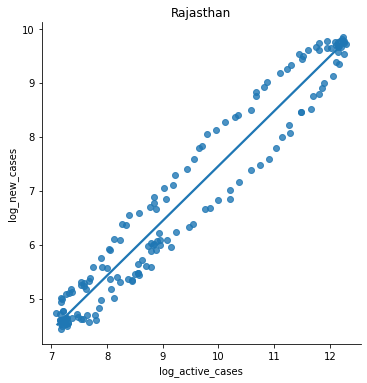

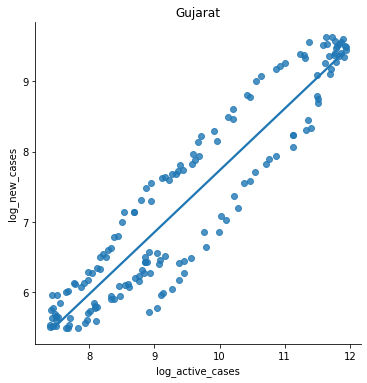

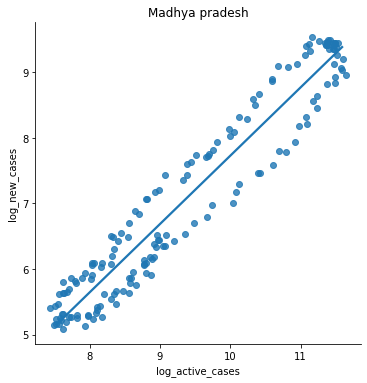

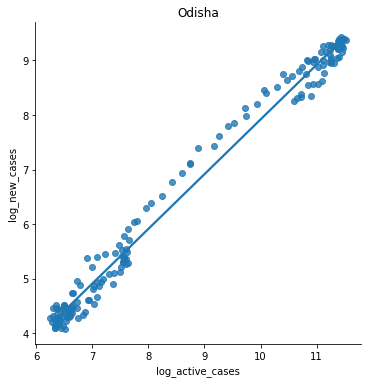

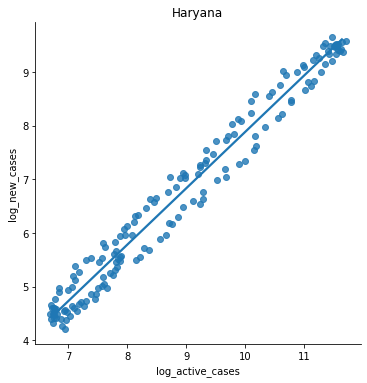

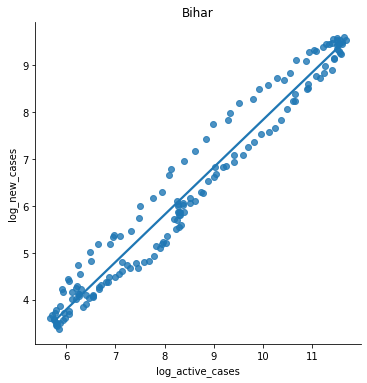

In [ ]:
for state in log_dict:
  sns.lmplot(x = 'log_active_cases', y = 'log_new_cases', data = log_dict[state], ci = None, x_jitter=0.1, y_jitter=0.1, palette="Set2"); #jitter is only for aesthetic purposes
  plt.title(state)

The plots look promising.

Before we get started with the calculations, let us first take a look at the residuals. The difference between the observed value of the dependent variable ($y$) and the predicted value ($y_p$) is called the residual ($e$). Each data point has one residual. Both the sum and the mean of the residuals are equal to zero.

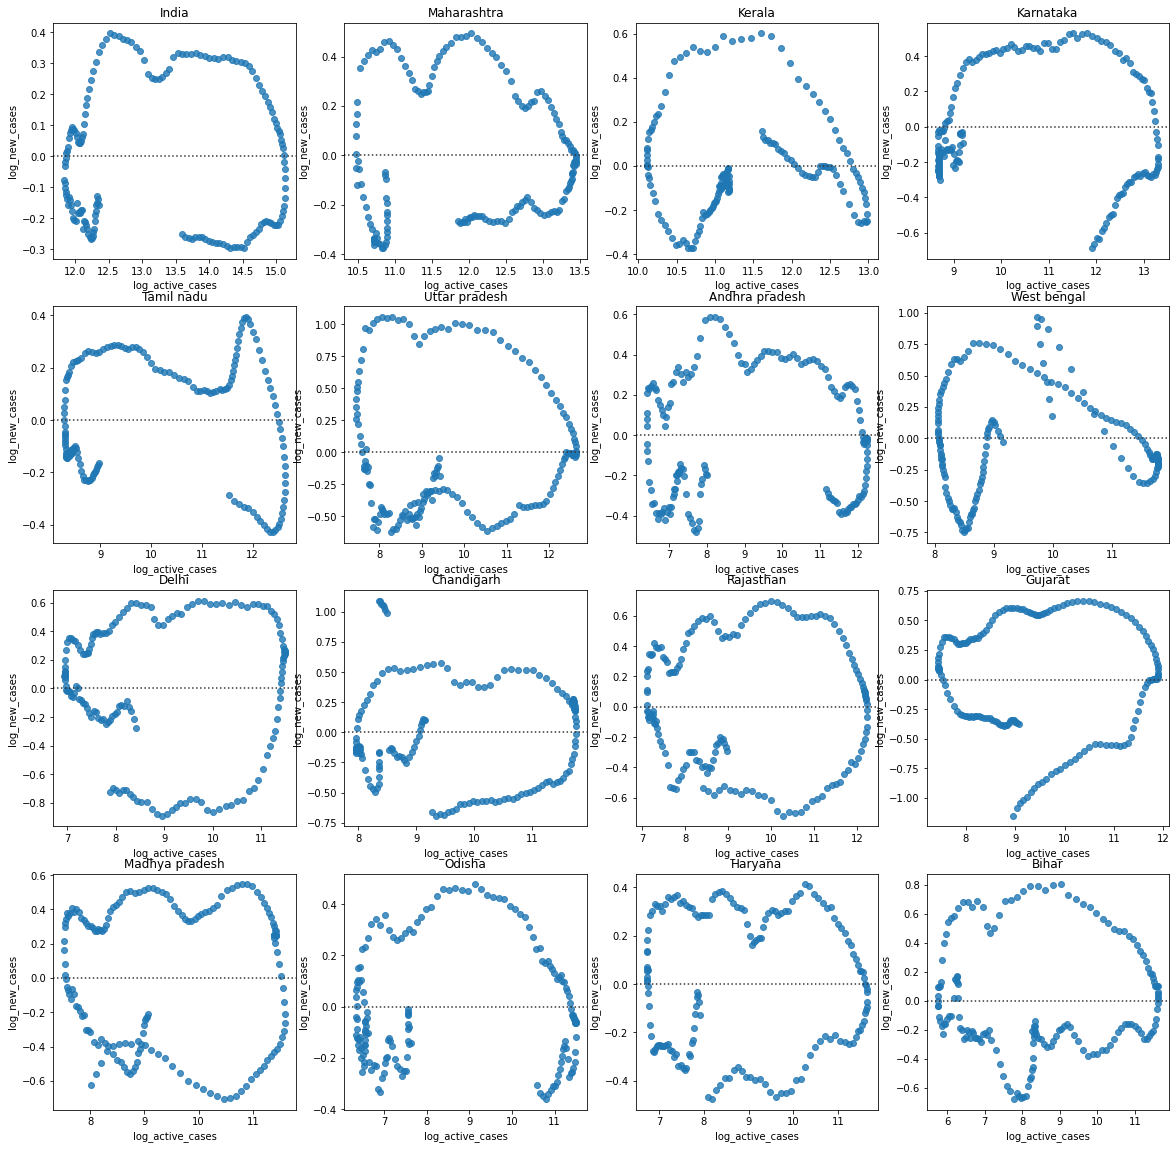

In [ ]:
plt.figure(figsize=(20,20))
for i,state in enumerate(log_dict):
  plt.subplot(4, 4, i+1)
  sns.residplot(x = 'log_active_cases', y = 'log_new_cases', data = log_dict[state]); #plots residuals
  plt.title(state)

Though the residuals are not totally random, the residuals have no particular shape like polynomial curves or low values or extremely high values. The values are not totally random because we took a 7 day moving average. Otherwise there would not be any clear pattern. Therefore we will stick to our model.

### Calculations

Let us now start dealing with numbers and calculations. We first take the case of Maharashtra.

In [ ]:
x = log_dict['Maharashtra']['log_new_cases']
X = sm.add_constant(x)      #for affine regression, i.e. for getting the intercept along with the slope we add a constant
y = log_dict['Maharashtra']['log_active_cases']
model = sm.OLS(y, X, missing='drop')     #OLS stands for Ordinary Least Squares
results = model.fit()
print(results.summary() )

                            OLS Regression Results                            
Dep. Variable:       log_active_cases   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     2808.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          3.04e-104
Time:                        20:29:11   Log-Likelihood:                -1.9158
No. Observations:                 164   AIC:                             7.832
Df Residuals:                     162   BIC:                             14.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5907      0.160     22.445

The above table has a lot of important data regarding regression. Firstly, the slope and the intercept values and their confidence intervals. Then the R_squared value give us an estimate of how good our model fits

Using statsmodels.api(sm.OLS), we found the data correspoding to our regression model. We will now compare this with our calculated values.

#### Custom-built Functions

In [ ]:
def fit(x, y):            #returns coefficients of affine regression
    return np.polyfit(x, y, 1)

def predict(coef, x):     #using the coefficients, returns the predicted values of y i.e. yp
    return coef[0]*x + coef[1]

def get_rsq(y, yp):       #returns the r^2 values
    sse = np.sum((yp - y)**2)
    ybar = np.mean(y)
    sst = np.sum((y - ybar)**2)
    #ssr = np.sum((yp - ybar)**2) #for curves that do not minimise the squared sum of errors
    ssr = sst - sse
    return ssr/sst

def fit_predict(x, y):
    coef = fit(x, y)
    yp = predict(coef, x)
    r2 = get_rsq(y, yp)
    return yp, r2, coef

In [ ]:
yp, r2, coef = fit_predict(x, y)

In [ ]:
np.max(np.abs(results.predict() - yp)) < 1e-12

True

In [ ]:
np.abs(results.rsquared - r2) < 1e-12

True

In [ ]:
np.abs(coef[::-1] - results.params) < 1e-12   #reversing i.e. [::-1] is because coef is in reverse order as compared to results.params

const            True
log_new_cases    True
dtype: bool

Since both the methods give the same value upto atleast 12 digits of accuracy, we have confirmed our calculations. For further calculations, we will use the methods provided by the imported module.

### Final Plotting

The following plots show the actual data values, the predicted values and a 95% confidence interval. 

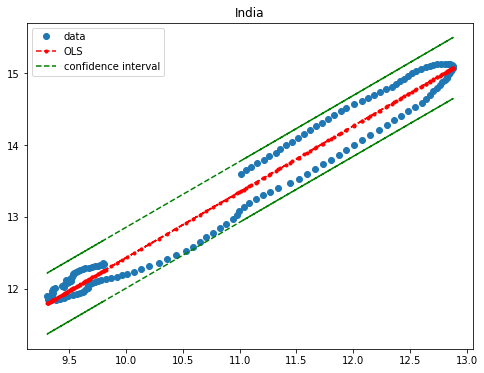

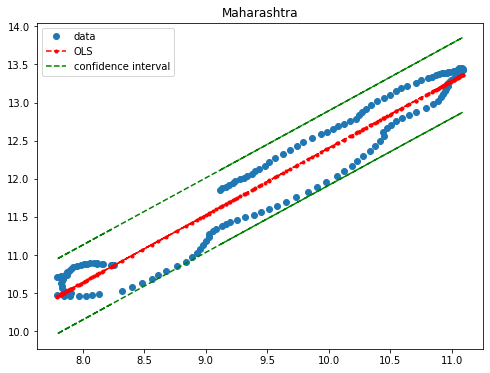

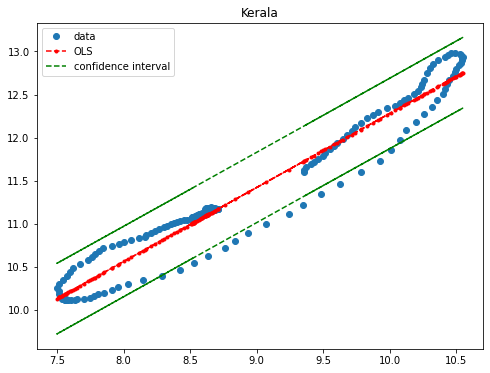

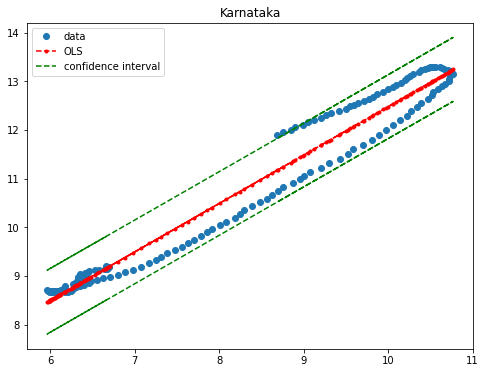

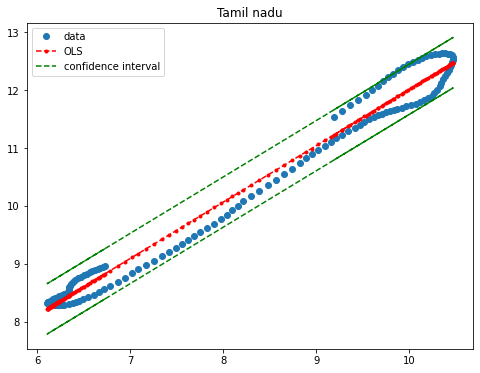

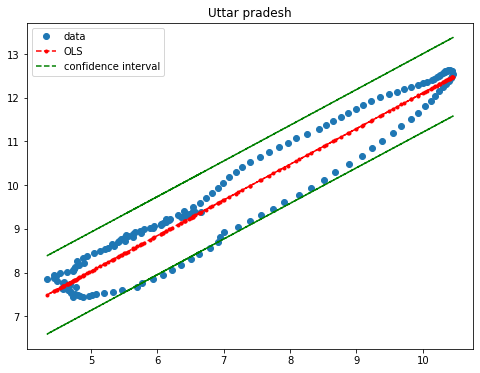

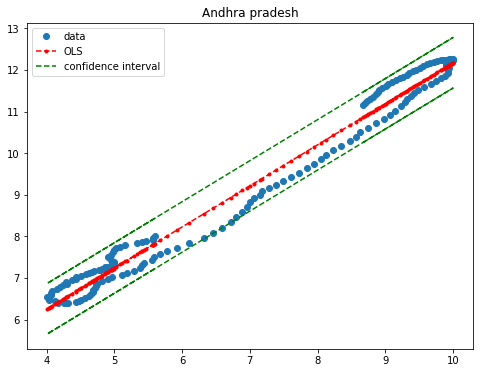

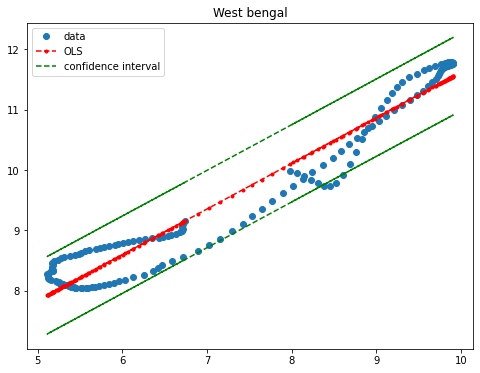

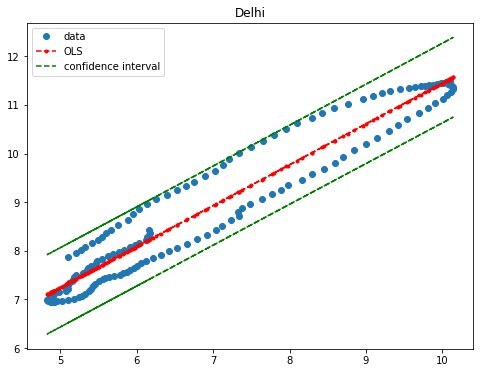

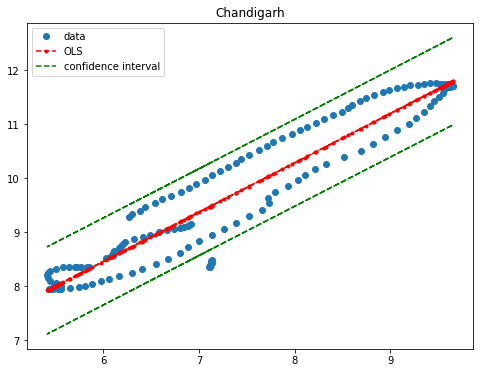

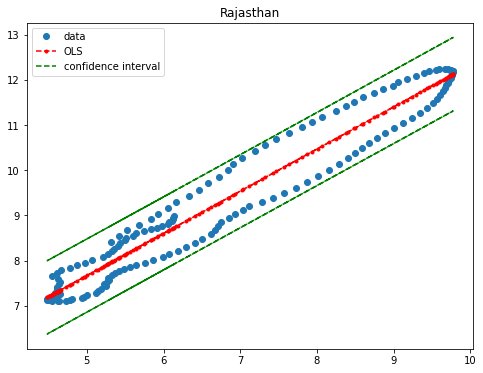

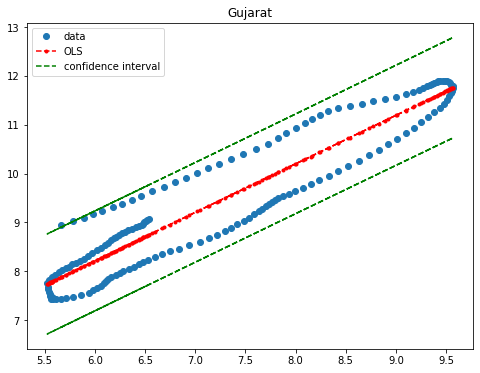

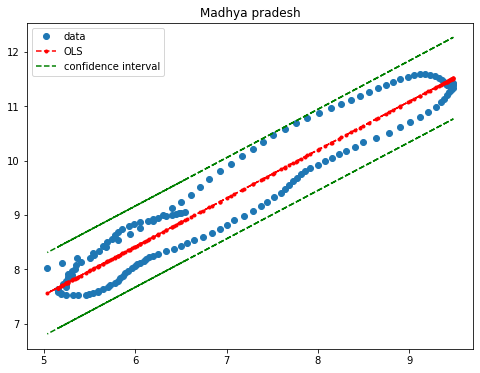

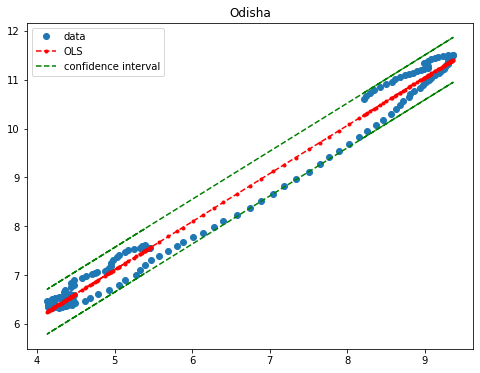

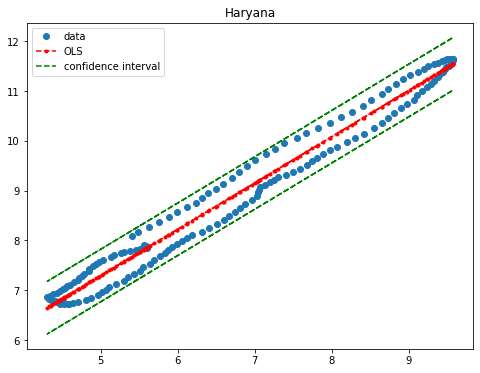

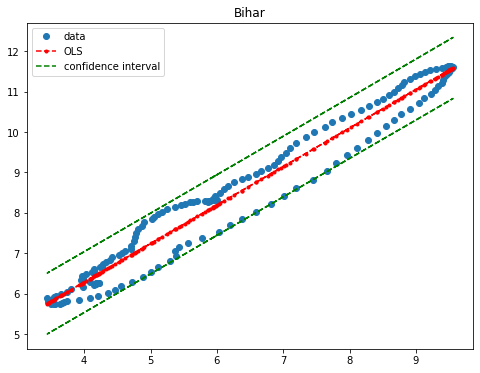

In [ ]:
for state in log_dict:
  x = log_dict[state]['log_new_cases']
  X = sm.add_constant(x)
  y = log_dict[state]['log_active_cases']
  model = sm.OLS(y, X, missing='drop')
  results = model.fit()
  prstd, iv_l, iv_u = wls_prediction_std(results) #iv_l, iv_u are the upper and lower bounds i.e. confidence interval

  fig, ax = plt.subplots(figsize=(8,6))

  ax.plot(x, y, 'o', label="data")
  ax.plot(x, results.fittedvalues, 'r--.', label="OLS")   #OLS stands for Ordinary Least Squares
  ax.plot(x, iv_u, 'g--', label = 'confidence interval')
  ax.plot(x, iv_l, 'g--')
  ax.legend(loc='best');
  plt.title(state)

### Summary

The following function summarises the data obtained from the above regression based analysis. It creates a dataframe containing R^2 values (determining how good our fit was), Intercept, Slope, Average Duration(in days), Confidence interval of the duration(in days).

In [ ]:
reg_list = []
for state in log_dict:
  x = log_dict[state]['log_new_cases']
  X = sm.add_constant(x)
  y = log_dict[state]['log_active_cases']
  model = sm.OLS(y, X, missing='drop')
  results = model.fit()
  reg_list.append([results.rsquared, results.params[0], results.params[1], np.exp(results.params[0]),
                     np.exp(results.conf_int(0.05)[0]['const']), np.exp(results.conf_int(0.05)[1]['const'])] )
reg_df = pd.DataFrame(reg_list, columns = ['R^2', 'Intercept', 'Slope', 'Average Duration', 'Lower limit', 'Upper limit'], index = log_dict.keys())
reg_df['Correlation Coefficients'] = corr_list

In [ ]:
reg_df

,R^2,Intercept,Slope,Average Duration,Lower limit,Upper limit,Correlation Coefficients
India,0.969150,3.256881,0.917397,25.968406,19.630532,34.352515,0.984454
Maharashtra,0.945460,3.590736,0.881340,36.260763,26.438463,49.732201,0.972348
Kerala,0.944427,3.683057,0.859673,39.767789,29.731282,53.192360,0.971816
Karnataka,0.966394,2.523810,0.995386,12.476038,9.825963,15.840843,0.983053
Tamil nadu,0.982817,2.265815,0.975041,9.638982,8.183081,11.353910,0.991371
Uttar pradesh,0.932685,3.953489,0.815206,52.116897,40.612953,66.879424,0.965756
Andhra pradesh,0.980881,2.307582,0.986376,10.050094,8.594392,11.752360,0.990394
West bengal,0.947463,4.065172,0.755618,58.274915,47.296226,71.802044,0.973377
Delhi,0.933945,3.048427,0.840051,21.082152,16.443441,27.029449,0.966408
Chandigarh,0.918566,2.978505,0.913976,19.658400,14.297615,27.029173,0.958419


### Results

$ \log_e{\text{Active Cases}} \text{  -vs-  } \log_e{\text{New Cases}} $ is nicely approximated by an straight line. 

Also, based on our model we have approximate data regarding the average duration of COVID-19 in different states of India.

# Thank You

### Contributions:

*   Rishi Datta(200010080):-    Data and its Source
*   Mrunal Lalwani(200010046):- True Distribution
*   Vishal (200010085):-        Sampling Distribution
*   Shivansh Chakrawarti(200010075):- Confidence intervals
*   Shiv Joshi(200010076):-     Hypothesis testing
*   Khush Jain(200010040):-     Regression analysis




Link to video: https://drive.google.com/file/d/1LjEqNrdWmD2DuTPA_WyR3Ay6Ht9rIQRH/view?usp=sharing